# Content

### 1. Find and Delete Invalid Images
- Invalid type of images
- Images with wrong size
 
### 2. Hypertuning
- Find the mean and std to use in normalisation
- Choose optimiser (Adam, SGD)
- Choose learning rate, batch_size, test_batch_size, momentum, epoch

### 3. Dropout, Batch Normalisation, and Data Augmentation
- Using dropout and Batch Normalisation generally increase the performance
- Data augmentation didn't really have a positive impact on my model

### Conclusion
- mean and std are set to be 0.271, 0.297
- Adam does a better job than SGD (I chose Adam)
- Using dropout and Batch Normalisation generally increase the performance (I chose model with these layers)
- An appropriate learning reate increases the performance (I chose 1e-3), too small the model might stuck in local minima, while too large might not converge
- An appropriate batch_size increases the genralisation (I chose 64)

# 1. Find and Delete Invalid Images

In [14]:
from PIL import Image, UnidentifiedImageError
import os

folders = ["/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands",
           "/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/VAE_hands",
           "/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/real_hands",
           "/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/test_hands"]

In [10]:
def find_and_delete_invalid_images():
    invalid_images = []
    for folder_path in folders:
        if os.path.isdir(folder_path):
            print(f"Checking folder: {folder_path}")
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    Image.open(file_path)
                except (IOError, UnidentifiedImageError):
                    if filename.endswith('.jpeg'):
                        invalid_images.append(file_path)
    
    return invalid_images

invalid_images = find_and_delete_invalid_images()

print("\nInvalid images found:")
for img_path in invalid_images:
    print(img_path)

Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands
Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/VAE_hands
Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/real_hands
Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/test_hands

Invalid images found:
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_147.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_273.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/test_hands/test_hand_3551.jpeg


In [11]:
for img_path in invalid_images:
    os.remove(img_path)

In [18]:
def find_images_with_wrong_size():
    wrong_size_images = []

    for folder_path in folders:
        if os.path.isdir(folder_path):
            print(f"Checking folder: {folder_path}")
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    image = Image.open(file_path)
                    width, height = image.size
                    if (width, height) != (32, 32):
                        wrong_size_images.append(file_path)
                except Exception:
                    if filename.endswith('.jpeg'):
                        print(f"Error processing {file_path}: {'Exception'}")

    return wrong_size_images

wrong_size_images = find_images_with_wrong_size()

print("\nInvalid images found:")
for img_path in wrong_size_images:
    print(img_path)

Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands
Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/VAE_hands
Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/real_hands
Checking folder: /Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/test_hands

Invalid images found:
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_371.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_171.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_506.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_099.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_426.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_257.jpeg
/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/GAN_hands/GAN_hand_217.jpeg
/Users/hs1623/Imperial/dlmodule-c

In [19]:
for img_path in wrong_size_images:
    os.remove(img_path)

# 2. Hyper Tuning

In [56]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import numpy as np
import random
from sklearn.metrics import accuracy_score

In [21]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label=None, transform=None):
        self.root_dir = root_dir
        self.label = label
        self.transform = transform

        # Get a list of all image filenames in the directory
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith(('.jpeg'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('L')  # convert from 3 channels to 1 channel
        label = self.label  # Assign different labels based on the dataset type

        if self.transform:
            image = self.transform(image)

        return image, label

In [191]:
# Find mean and std
transform = transforms.Compose([
        transforms.ToTensor(),  # No normalisation here, keep original
    ])

real_hands_dataset = CustomDataset(root_dir=f"{root_dir}/real_hands", label=0, transform=transform)
vae_hands_dataset = CustomDataset(root_dir=f"{root_dir}/VAE_hands", label=1, transform=transform)
gan_hands_dataset = CustomDataset(root_dir=f"{root_dir}/GAN_hands", label=2, transform=transform)
test_hands_dataset = CustomDataset(root_dir=f"{root_dir}/test_hands", transform=transform)

# Concatenate all training and validation datasets
whole_dataset = ConcatDataset([real_hands_dataset, vae_hands_dataset, gan_hands_dataset])
# Note: Notest_hands_dataset as it's only used for testing.

print(whole_dataset)
print(whole_dataset[0]) # an example of calling  __getitem__, which is what the dataloader does

(tensor([[[0.3765, 0.3686, 0.3569,  ..., 0.2667, 0.2510, 0.4706],
         [0.2314, 0.2314, 0.2275,  ..., 0.2392, 0.2275, 0.4471],
         [0.2549, 0.2353, 0.2157,  ..., 0.2039, 0.1922, 0.4118],
         ...,
         [0.2510, 0.1137, 0.1098,  ..., 0.1098, 0.1412, 0.1725],
         [0.2824, 0.1608, 0.1255,  ..., 0.1255, 0.1412, 0.1647],
         [0.2588, 0.2118, 0.1882,  ..., 0.2627, 0.2706, 0.2863]]]), 0)


In [192]:
# Get mean and std of the whole dataset 
# (since we random split, so instad of just calculating trainset, I take mean and std on the whole dataset)
tmp_loader = DataLoader(whole_dataset, batch_size=1421, num_workers=0)
data = next(iter(tmp_loader))
print(len(tmp_loader))
print(len(data[0]))

mean_list = [torch.mean(data[0][i][0].flatten()).item() for i in range(batch_size)]
std_list = [torch.std(data[0][i][0].flatten()).item() for i in range(batch_size)]
mean = sum(mean_list) / batch_size
std = sum(std_list) / batch_size
print(mean, std)

1
1421
0.2709243573481217 0.2972408983623609


In [193]:
# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),  # Normalize to [-1, 1], mean and std are found above
])

root_dir = "/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623"

# Load datasets
real_hands_dataset = CustomDataset(root_dir=f"{root_dir}/real_hands", label=0, transform=transform)
vae_hands_dataset = CustomDataset(root_dir=f"{root_dir}/VAE_hands", label=1, transform=transform)
gan_hands_dataset = CustomDataset(root_dir=f"{root_dir}/GAN_hands", label=2, transform=transform)
test_hands_dataset = CustomDataset(root_dir=f"{root_dir}/test_hands", transform=transform)

In [194]:
# Split real_hands dataset into training and validation sets
def split_size(dataset):
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    return train_size, val_size

train_size, val_size = split_size(real_hands_dataset)
real_train_dataset, real_val_dataset = random_split(real_hands_dataset, [train_size, val_size])

train_size, val_size = split_size(vae_hands_dataset)
vae_train_dataset, vae_val_dataset = random_split(vae_hands_dataset, [train_size, val_size])

train_size, val_size = split_size(gan_hands_dataset)
gan_train_dataset, gan_val_dataset = random_split(gan_hands_dataset, [train_size, val_size])

# Concatenate all training and validation datasets
train_dataset = ConcatDataset([real_train_dataset, vae_train_dataset, gan_train_dataset])
val_dataset = ConcatDataset([real_val_dataset, vae_val_dataset, gan_val_dataset])

# Note: No need to split test_hands_dataset as it's only used for testing.


# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [73]:
# Step 2: Define the Neural Network Model
class CNNClassifier(nn.Module):
    # implement our own version of LeNet5
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*5*5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        return self.output(x)

model = CNNClassifier()
print(model)

CNNClassifier(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


In [74]:
# Provided Train, Validation and Evaluate Functions
device = 'cpu'

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 32, 32))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 32, 32))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 32, 32))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [67]:
seed = 42
lr = 1e-2
batch_size = 64
test_batch_size = 1000
n_epochs = 100

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

In [68]:
def train_adam_model(lr=1e-2, batch_size=64, test_batch_size=1000, n_epochs=100):
    set_seed(seed)
    model = CNNClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_hands_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, val_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

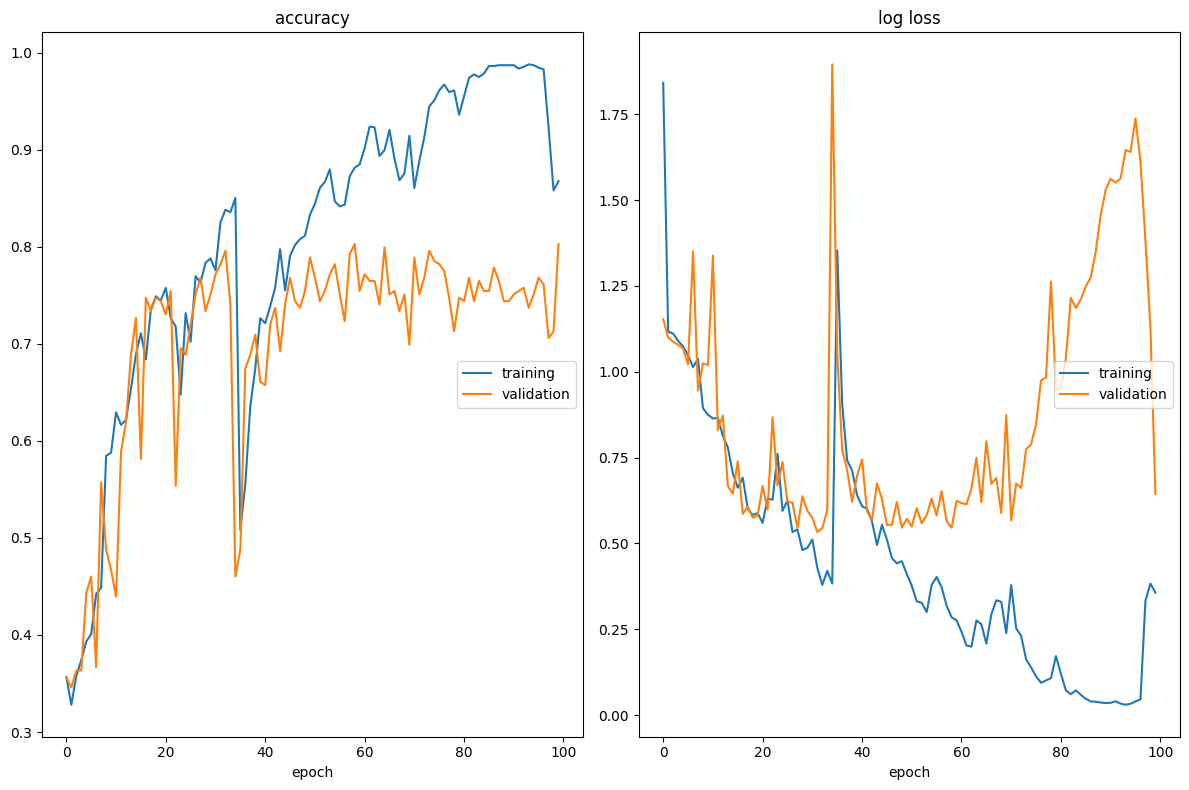

accuracy
	training         	 (min:    0.328, max:    0.988, cur:    0.868)
	validation       	 (min:    0.346, max:    0.803, cur:    0.803)
log loss
	training         	 (min:    0.030, max:    1.841, cur:    0.357)
	validation       	 (min:    0.533, max:    1.895, cur:    0.644)


In [32]:
model = train_adam_model()

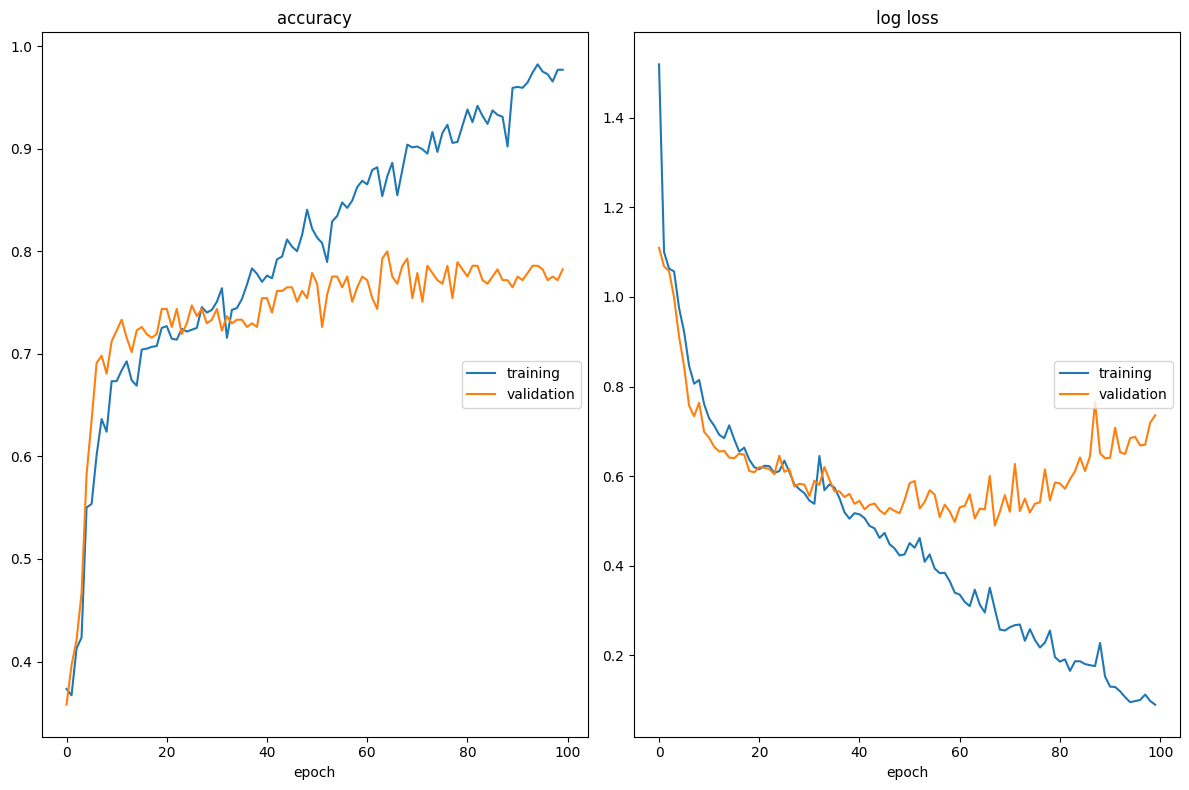

accuracy
	training         	 (min:    0.367, max:    0.982, cur:    0.977)
	validation       	 (min:    0.358, max:    0.800, cur:    0.782)
log loss
	training         	 (min:    0.090, max:    1.519, cur:    0.090)
	validation       	 (min:    0.490, max:    1.109, cur:    0.736)


In [75]:
model = train_adam_model(lr=1e-3)

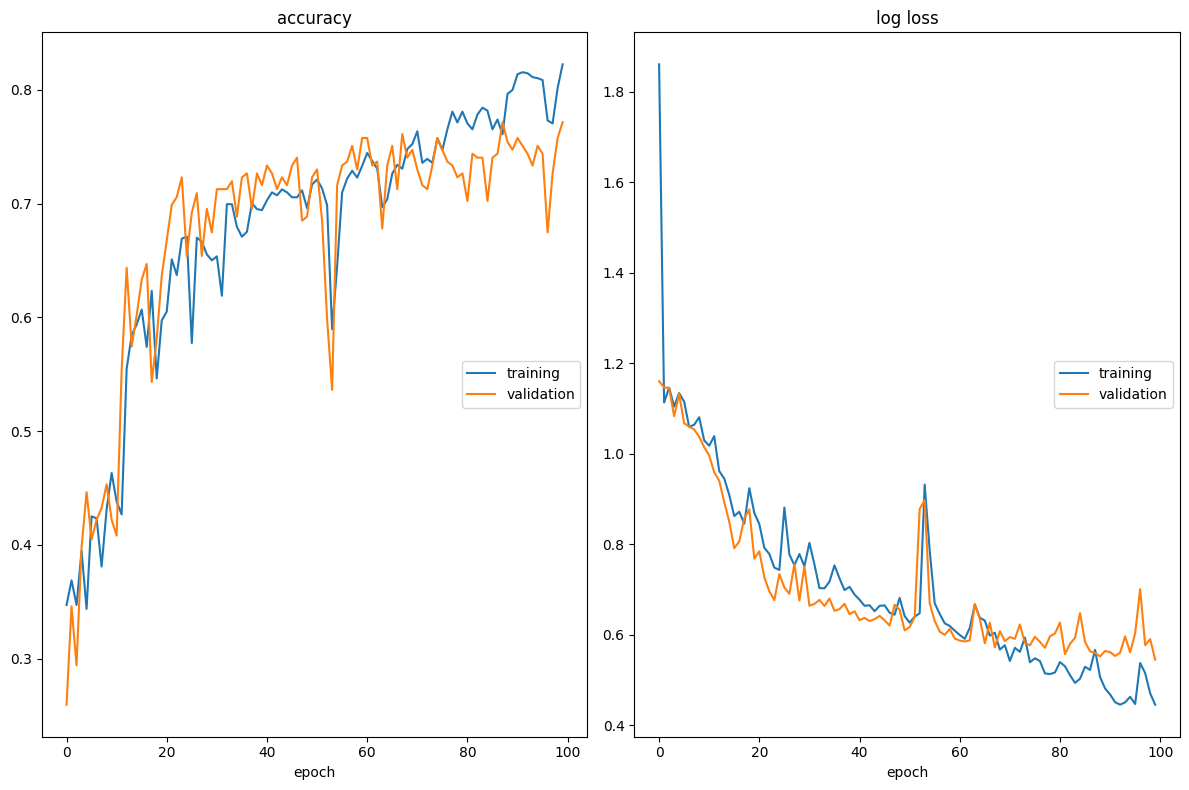

accuracy
	training         	 (min:    0.344, max:    0.823, cur:    0.823)
	validation       	 (min:    0.260, max:    0.772, cur:    0.772)
log loss
	training         	 (min:    0.445, max:    1.861, cur:    0.445)
	validation       	 (min:    0.545, max:    1.160, cur:    0.545)


In [33]:
model = train_adam_model(lr=1e-3, batch_size=128)

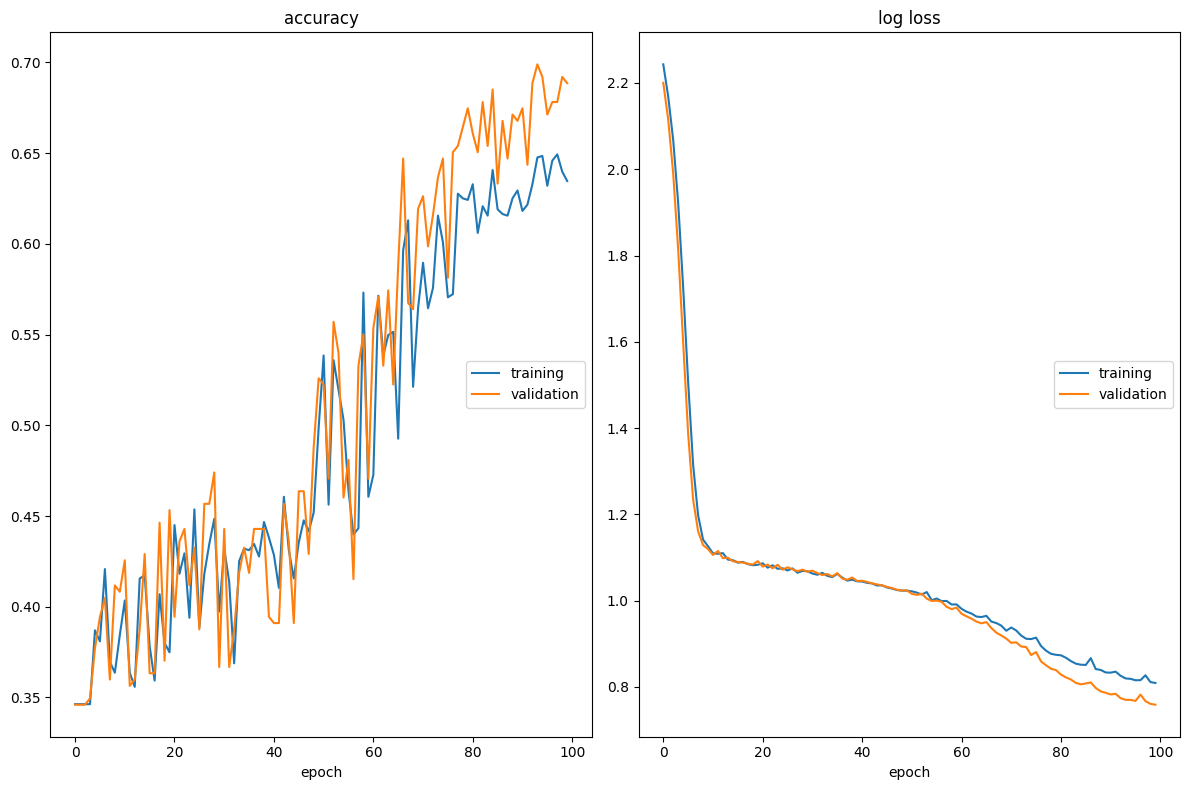

accuracy
	training         	 (min:    0.346, max:    0.649, cur:    0.635)
	validation       	 (min:    0.346, max:    0.699, cur:    0.689)
log loss
	training         	 (min:    0.809, max:    2.243, cur:    0.809)
	validation       	 (min:    0.759, max:    2.200, cur:    0.759)


In [36]:
model = train_adam_model(lr=1e-4, batch_size=128)

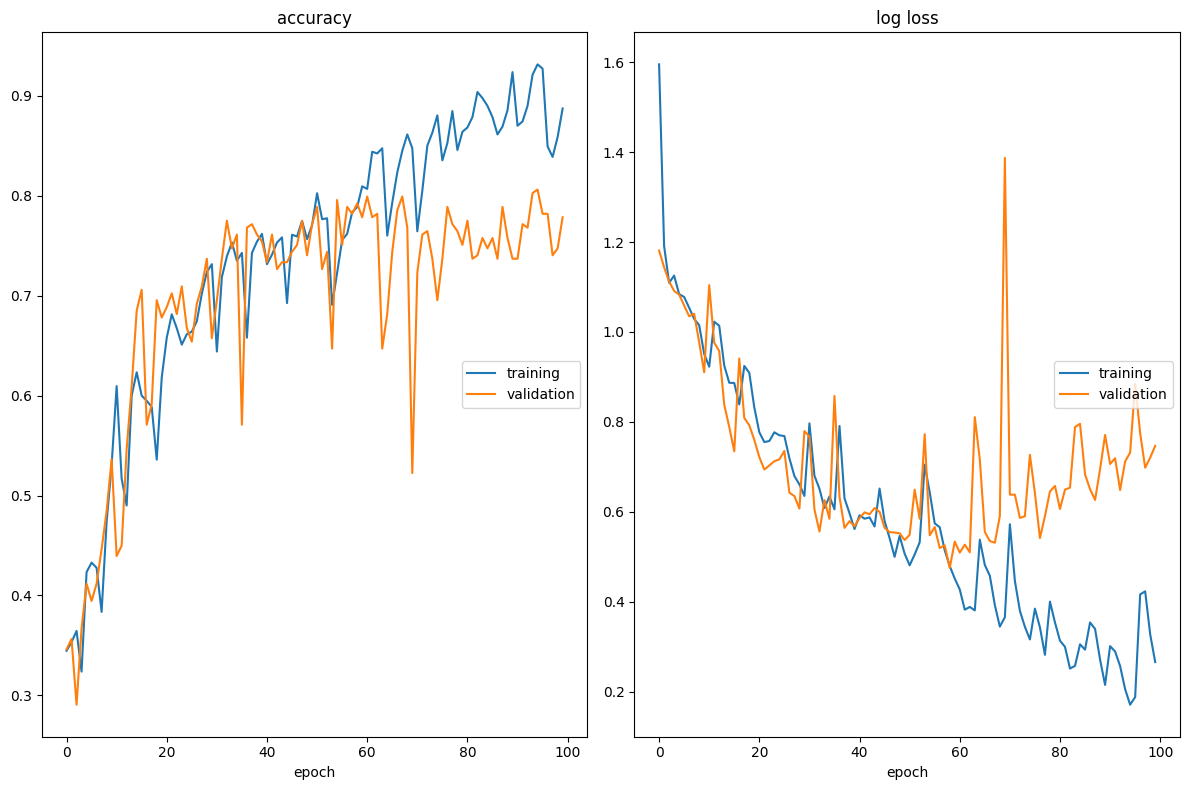

accuracy
	training         	 (min:    0.324, max:    0.932, cur:    0.887)
	validation       	 (min:    0.291, max:    0.806, cur:    0.779)
log loss
	training         	 (min:    0.172, max:    1.595, cur:    0.266)
	validation       	 (min:    0.475, max:    1.387, cur:    0.747)


In [35]:
model = train_adam_model(lr=5e-3, batch_size=128)

In [28]:
def train_sgd_model(lr=1e-2, batch_size=64, test_batch_size=1000, n_epochs=100, momentum=0.5):
    set_seed(seed)
    model = CNNClassifier().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_hands_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, val_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

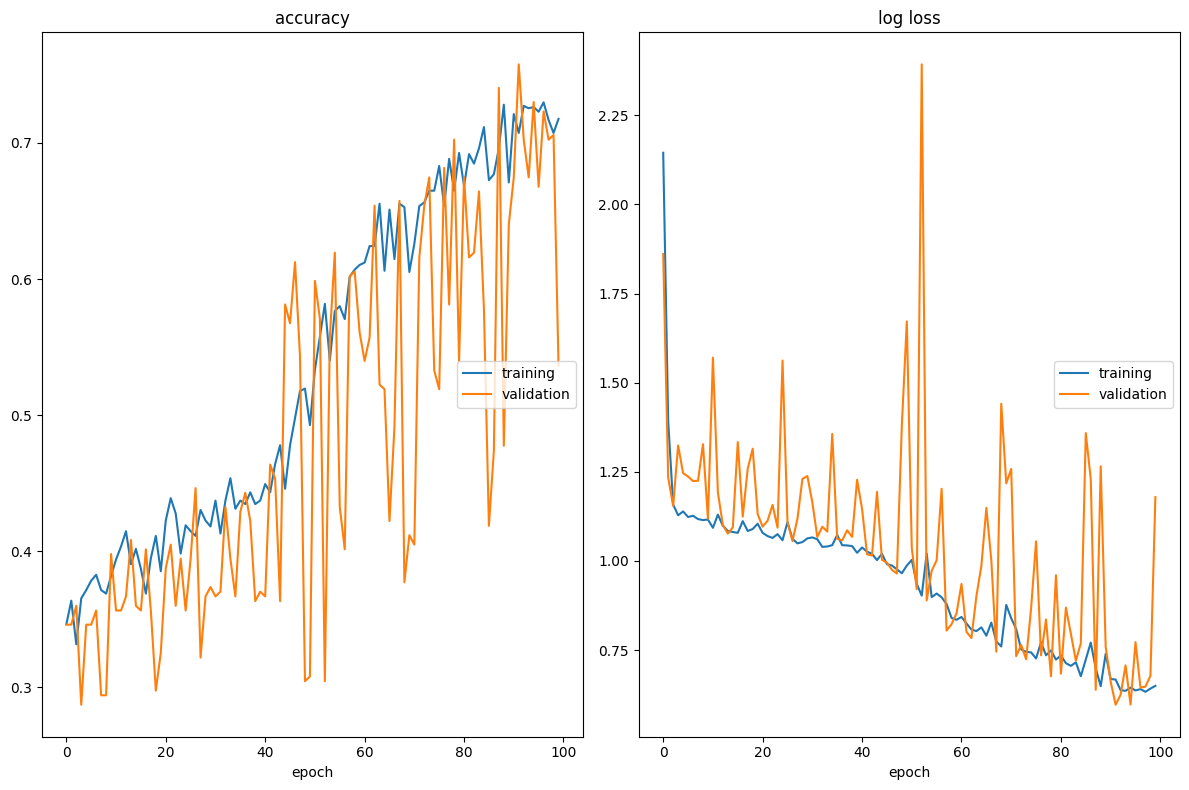

accuracy
	training         	 (min:    0.332, max:    0.730, cur:    0.718)
	validation       	 (min:    0.287, max:    0.758, cur:    0.536)
log loss
	training         	 (min:    0.633, max:    2.145, cur:    0.649)
	validation       	 (min:    0.597, max:    2.393, cur:    1.179)


In [29]:
model = train_sgd_model()

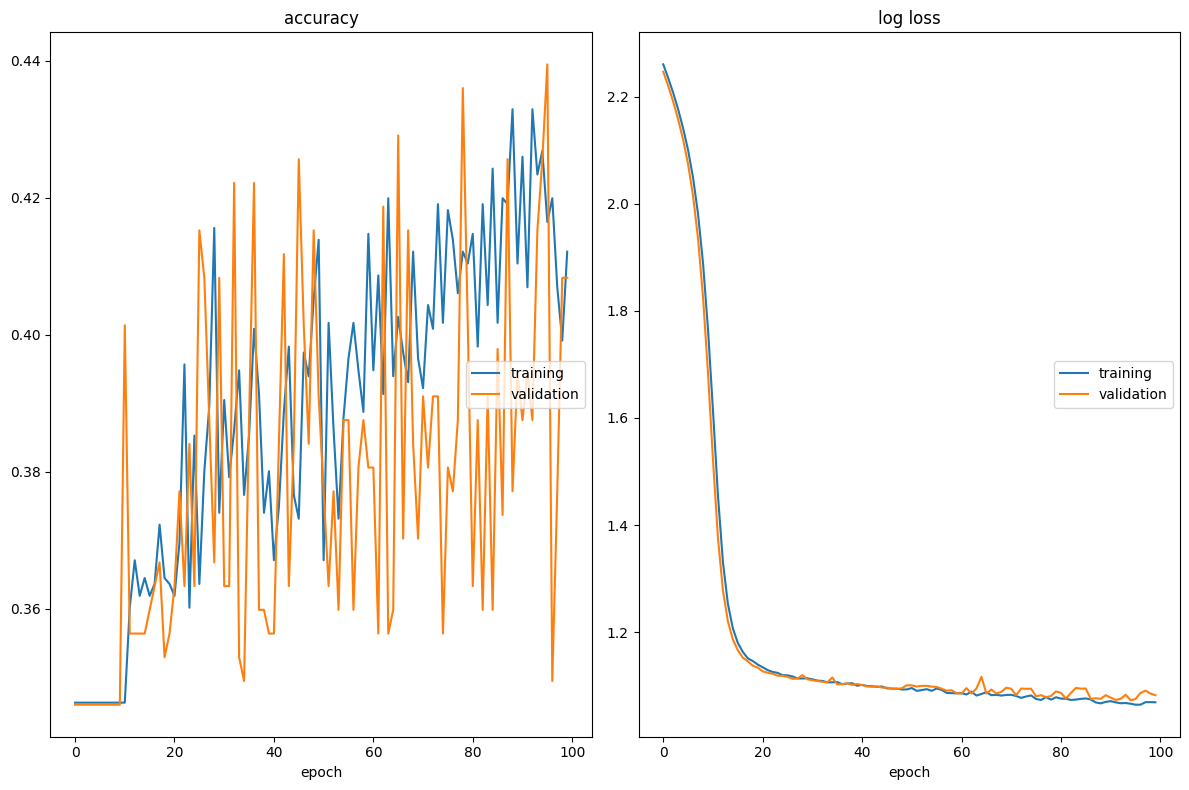

accuracy
	training         	 (min:    0.346, max:    0.433, cur:    0.412)
	validation       	 (min:    0.346, max:    0.439, cur:    0.408)
log loss
	training         	 (min:    1.065, max:    2.260, cur:    1.069)
	validation       	 (min:    1.073, max:    2.246, cur:    1.082)


In [34]:
model = train_sgd_model(lr=1e-3)

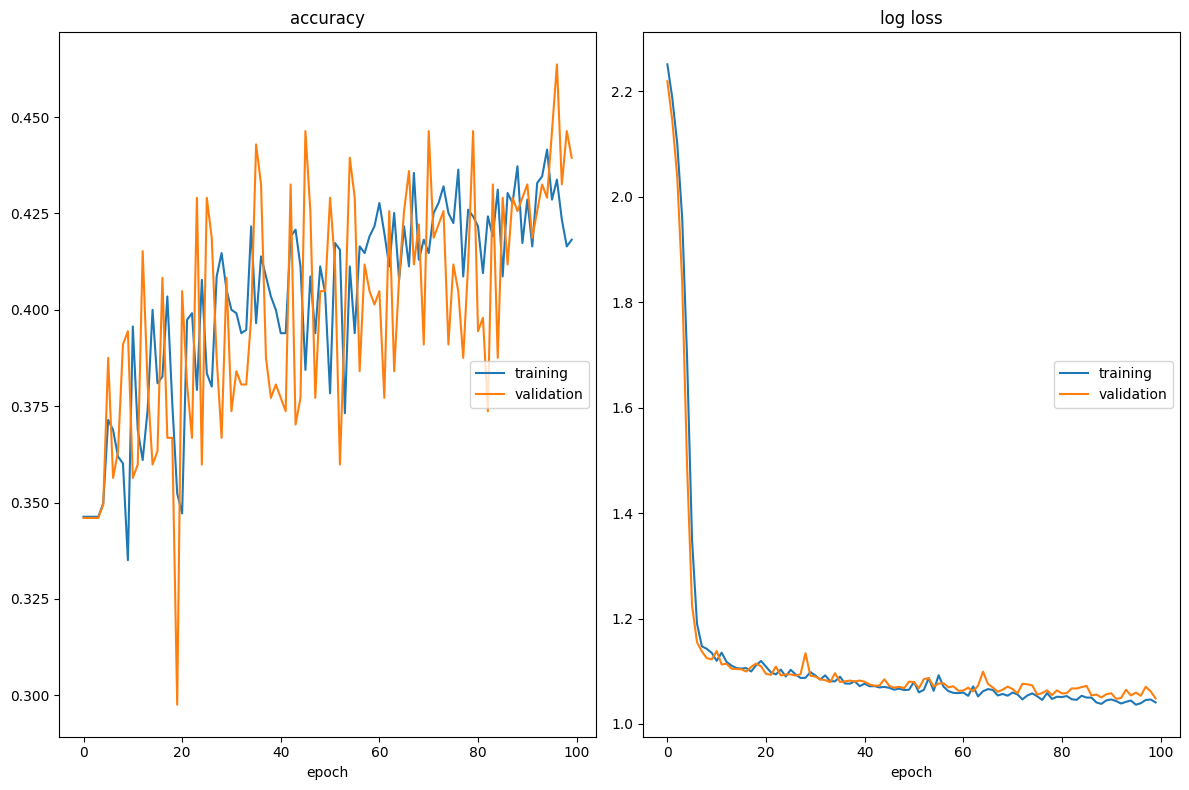

accuracy
	training         	 (min:    0.335, max:    0.442, cur:    0.418)
	validation       	 (min:    0.298, max:    0.464, cur:    0.439)
log loss
	training         	 (min:    1.037, max:    2.252, cur:    1.041)
	validation       	 (min:    1.048, max:    2.219, cur:    1.049)


In [31]:
model = train_sgd_model(lr=1e-3, momentum=0.8)

### Observation
- Adam does a better job than SGD (I chose Adam)
- An appropriate learning reate increases the performance (I chose 1e-3), too small the model might stuck in local minima, while too large might not converge
- An appropriate batch_size increases the genralisation (I chose 128)

# 3. Dropout and Batch Normalisation

In [195]:
class CNNClassifier2(nn.Module):
    def __init__(self):
        super(CNNClassifier2, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.s2_bn = nn.BatchNorm2d(6)
#         self.s2_dr = nn.Dropout2d(p=0.2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
#         self.c3_bn = nn.BatchNorm2d(16)
        self.c3_dr = nn.Dropout2d(p=0.5)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*5*5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))      
        x = self.act(self.s2_bn(self.s2(x)))                  
#         x = self.s2_dr(x)                                    
#         x = self.act(self.c3_bn(self.c3(x)))                                 
        x = self.act(self.c3(x))
        x = self.c3_dr(x)
        x = self.act(self.s4(x))                                    
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))              
        x = self.act(self.c5(x))                             
        x = self.act(self.f6(x))                                   
        return self.output(x)  
    
model = CNNClassifier2()

In [196]:
def train_model_drbn(lr=1e-3, batch_size=128, test_batch_size=1000, n_epochs=100):
    set_seed(seed)
    model = CNNClassifier2().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_hands_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, val_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

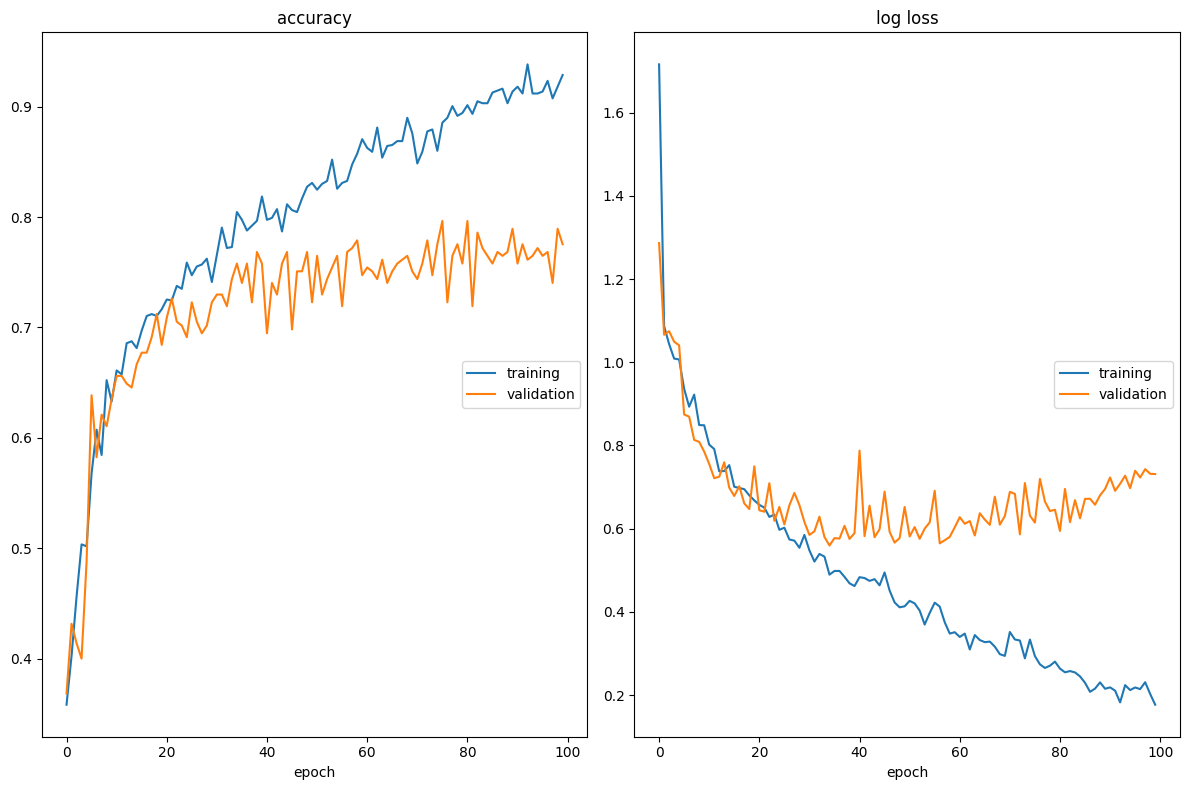

accuracy
	training         	 (min:    0.358, max:    0.938, cur:    0.929)
	validation       	 (min:    0.368, max:    0.796, cur:    0.775)
log loss
	training         	 (min:    0.177, max:    1.716, cur:    0.177)
	validation       	 (min:    0.560, max:    1.286, cur:    0.731)


In [48]:
model = train_model_drbn()

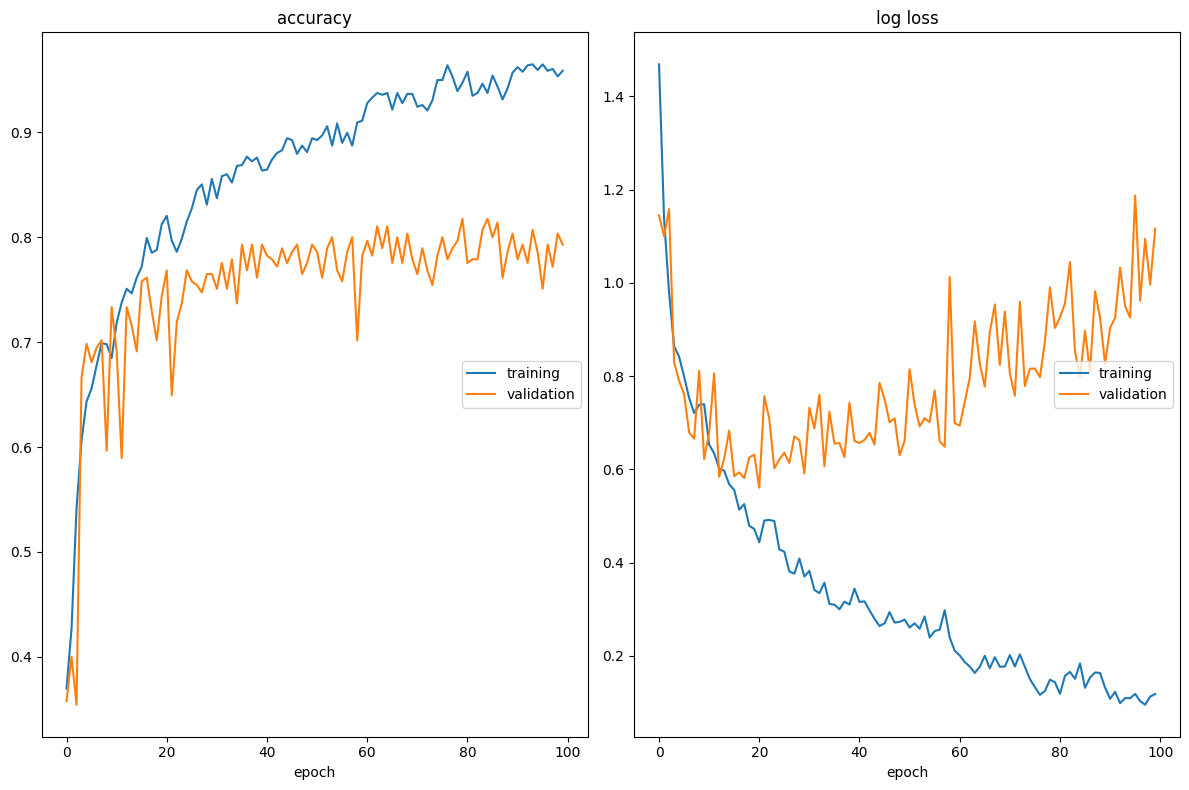

accuracy
	training         	 (min:    0.370, max:    0.965, cur:    0.959)
	validation       	 (min:    0.354, max:    0.818, cur:    0.793)
log loss
	training         	 (min:    0.095, max:    1.469, cur:    0.118)
	validation       	 (min:    0.561, max:    1.187, cur:    1.116)


In [198]:
model = train_model_drbn(lr=5e-3)

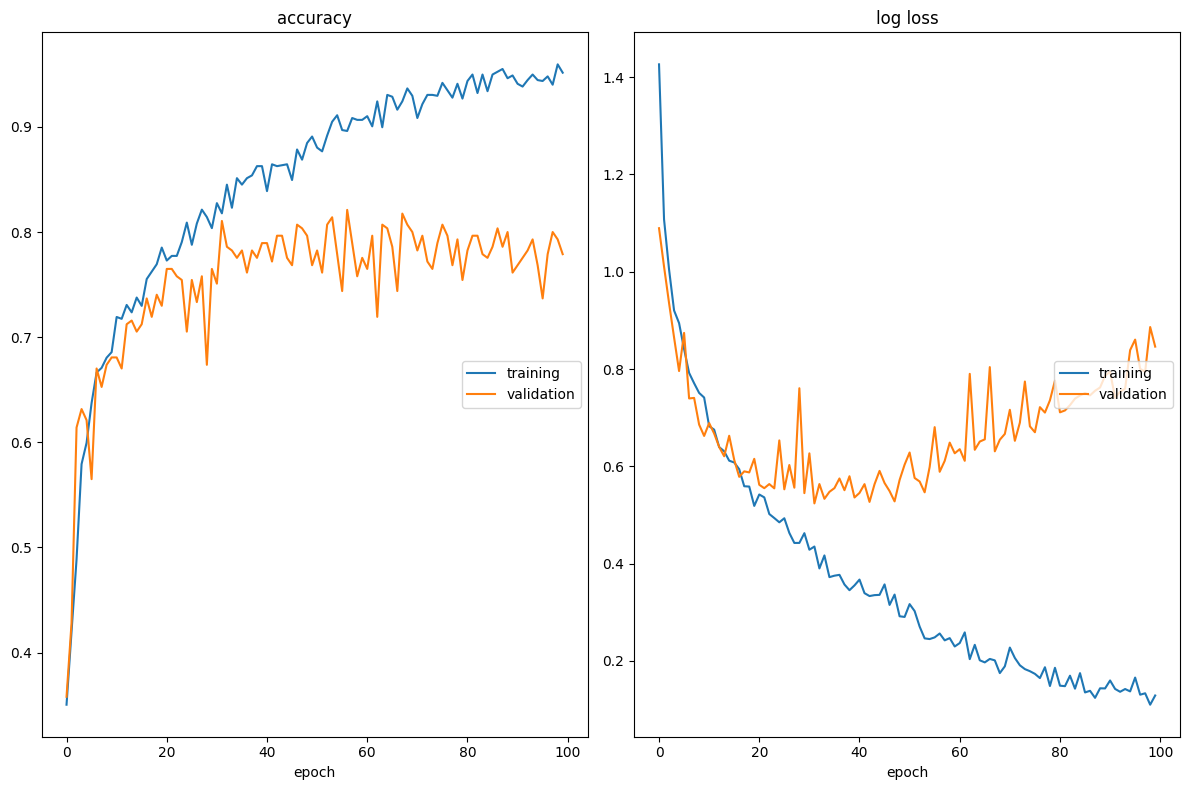

accuracy
	training         	 (min:    0.350, max:    0.960, cur:    0.952)
	validation       	 (min:    0.358, max:    0.821, cur:    0.779)
log loss
	training         	 (min:    0.110, max:    1.426, cur:    0.129)
	validation       	 (min:    0.524, max:    1.089, cur:    0.846)


In [50]:
model = train_model_drbn(batch_size=64)

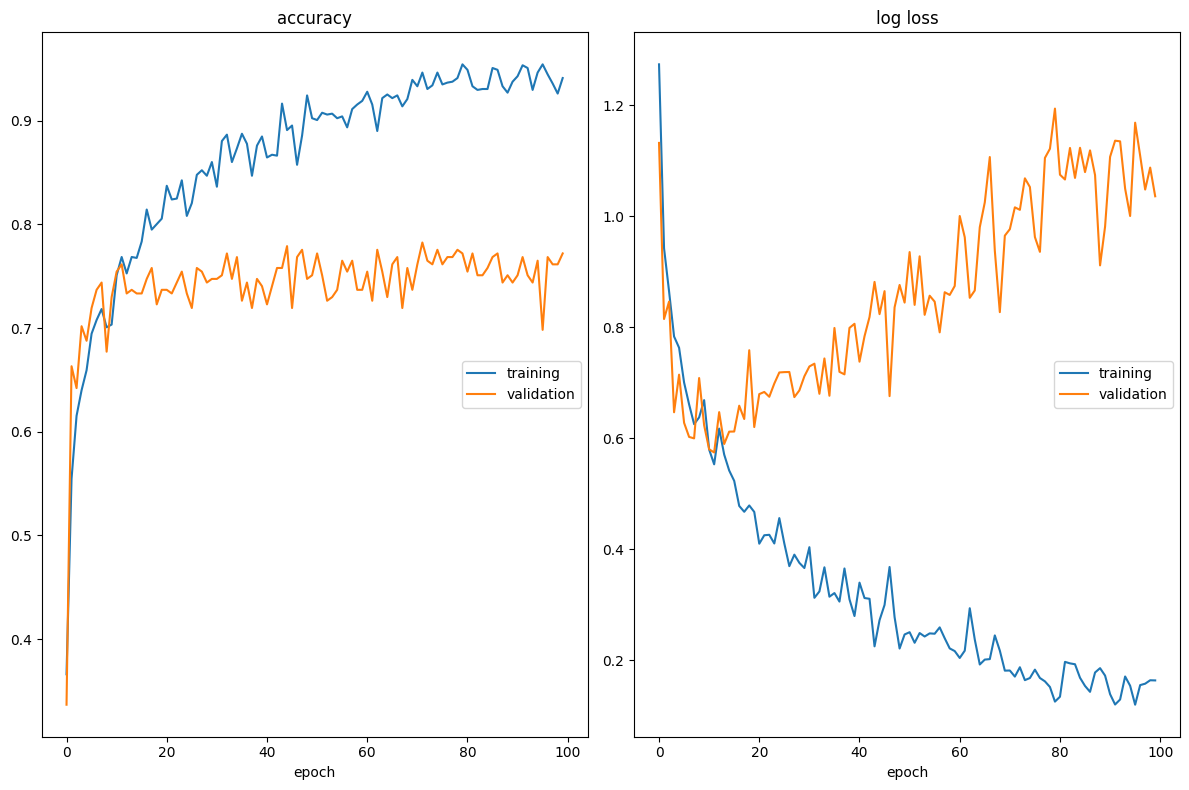

accuracy
	training         	 (min:    0.366, max:    0.954, cur:    0.941)
	validation       	 (min:    0.337, max:    0.782, cur:    0.772)
log loss
	training         	 (min:    0.119, max:    1.274, cur:    0.163)
	validation       	 (min:    0.574, max:    1.194, cur:    1.036)


In [200]:
model = train_model_drbn(lr=5e-3, batch_size=64)

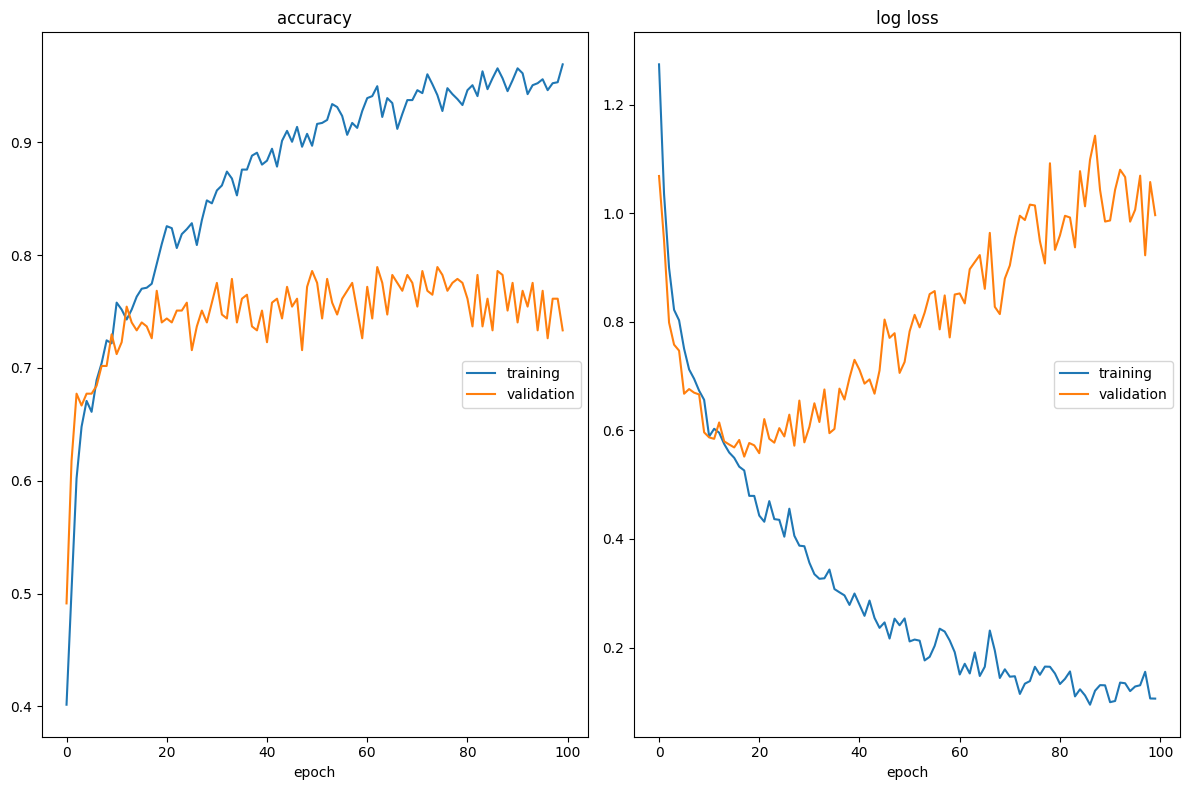

accuracy
	training         	 (min:    0.401, max:    0.969, cur:    0.969)
	validation       	 (min:    0.491, max:    0.789, cur:    0.733)
log loss
	training         	 (min:    0.095, max:    1.274, cur:    0.106)
	validation       	 (min:    0.552, max:    1.143, cur:    0.996)


In [201]:
model = train_model_drbn(lr=2e-3, batch_size=64)

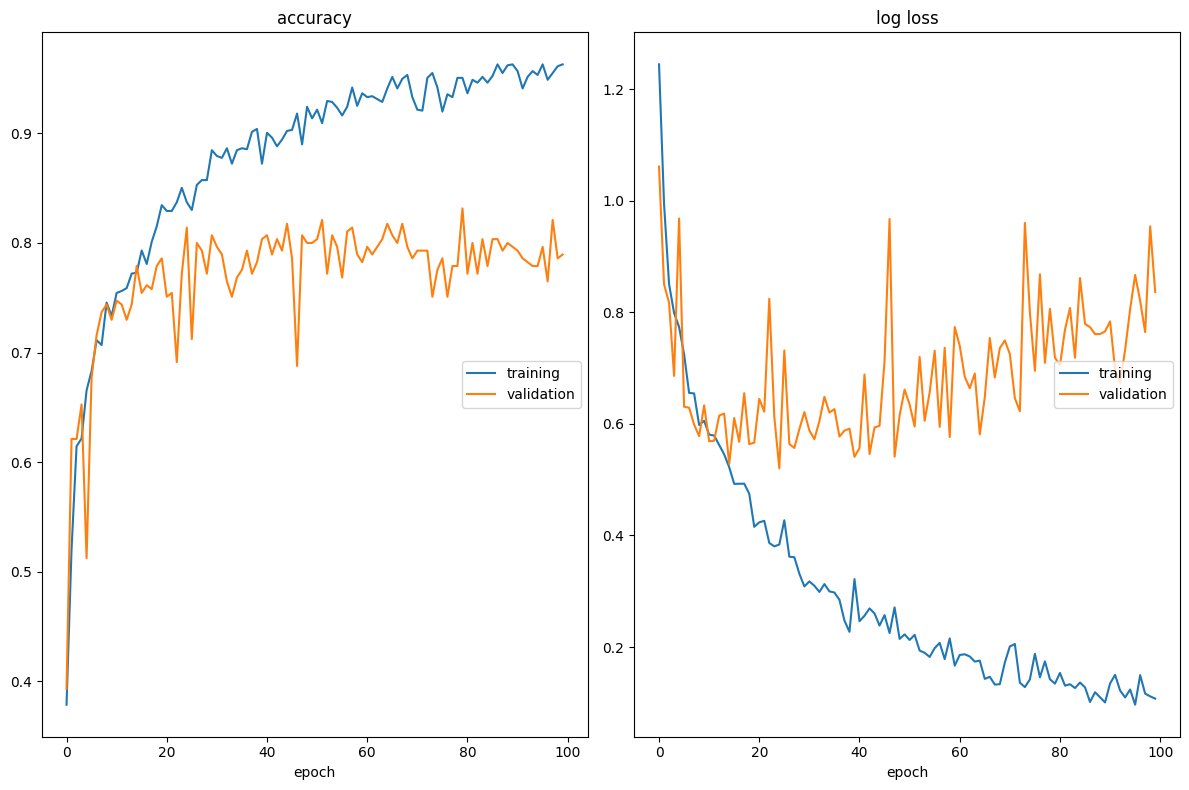

accuracy
	training         	 (min:    0.379, max:    0.963, cur:    0.963)
	validation       	 (min:    0.393, max:    0.832, cur:    0.789)
log loss
	training         	 (min:    0.097, max:    1.244, cur:    0.108)
	validation       	 (min:    0.520, max:    1.061, cur:    0.836)


In [53]:
model = train_model_drbn(lr=2e-3, batch_size=32)

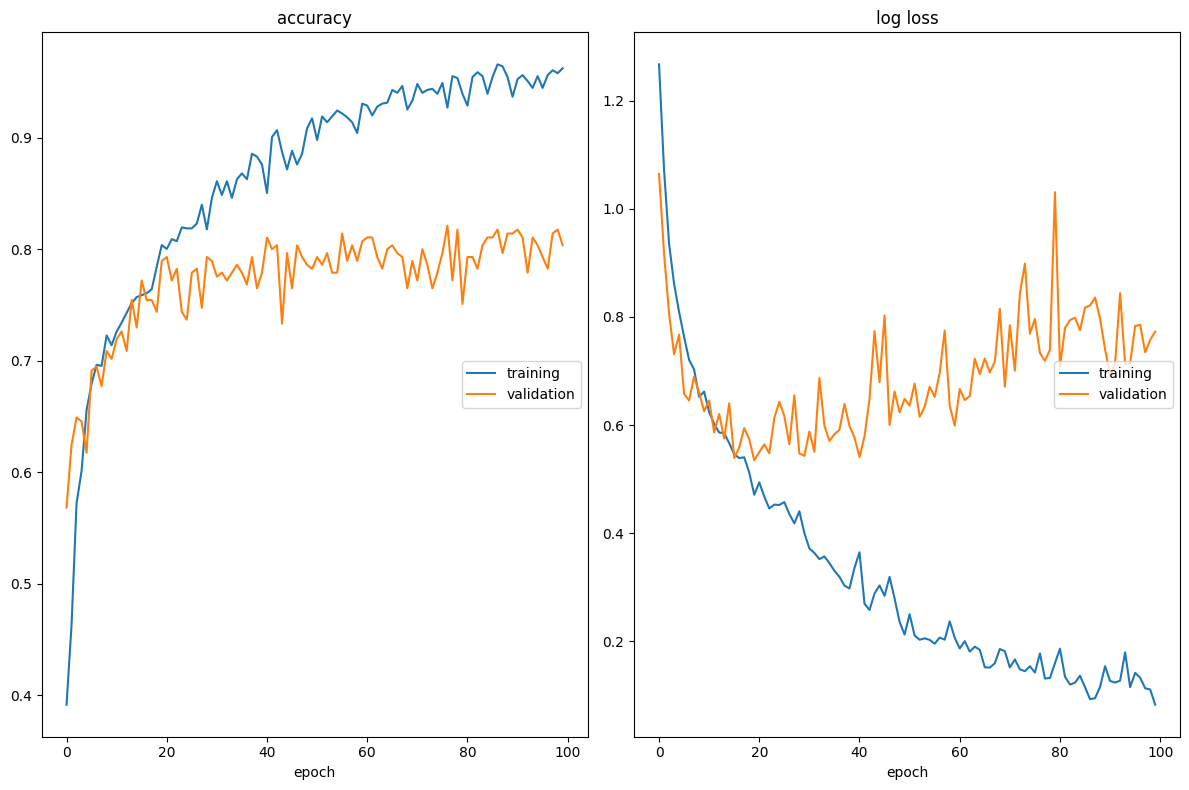

accuracy
	training         	 (min:    0.392, max:    0.966, cur:    0.962)
	validation       	 (min:    0.568, max:    0.821, cur:    0.804)
log loss
	training         	 (min:    0.083, max:    1.267, cur:    0.083)
	validation       	 (min:    0.535, max:    1.065, cur:    0.773)


In [54]:
model = train_model_drbn(lr=1e-3, batch_size=32)

### Observation

- adding dropout and batch normalisation generally increase the **stability** of the model a little bit
- when choosing lr=1e-3, batch_size=64, it gave the best parameters

# 3. Data Augmentation

In [76]:
#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform = Compose([
#     ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=0.5, std=0.5),
]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

#In Validation and Test Mode we only want to normalize our images, because they are already tensors
validation_test_transform = Compose([
    Normalize(mean=0.5, std=0.5)
])

# Load datasets
root_dir = "/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623"
real_hands_dataset = CustomDataset(root_dir=f"{root_dir}/real_hands", label=0, transform=train_transform)
vae_hands_dataset = CustomDataset(root_dir=f"{root_dir}/VAE_hands", label=1, transform=train_transform)
gan_hands_dataset = CustomDataset(root_dir=f"{root_dir}/GAN_hands", label=2, transform=train_transform)
test_hands_dataset = CustomDataset(root_dir=f"{root_dir}/test_hands", transform=validation_test_transform)

# Split real_hands dataset into training and validation sets
train_size = int(0.8 * len(real_hands_dataset))
val_size = len(real_hands_dataset) - train_size
real_train_dataset, real_val_dataset = random_split(real_hands_dataset, [train_size, val_size])

train_size = int(0.8 * len(vae_hands_dataset))
val_size = len(vae_hands_dataset) - train_size
vae_train_dataset, vae_val_dataset = random_split(vae_hands_dataset, [train_size, val_size])

train_size = int(0.8 * len(gan_hands_dataset))
val_size = len(gan_hands_dataset) - train_size
gan_train_dataset, gan_val_dataset = random_split(gan_hands_dataset, [train_size, val_size])

# Concatenate all training and validation datasets
train_dataset = ConcatDataset([real_train_dataset, vae_train_dataset, gan_train_dataset])
val_dataset = ConcatDataset([real_val_dataset, vae_val_dataset, gan_val_dataset])

# Note: No need to split test_hands_dataset as it's only used for testing.


# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

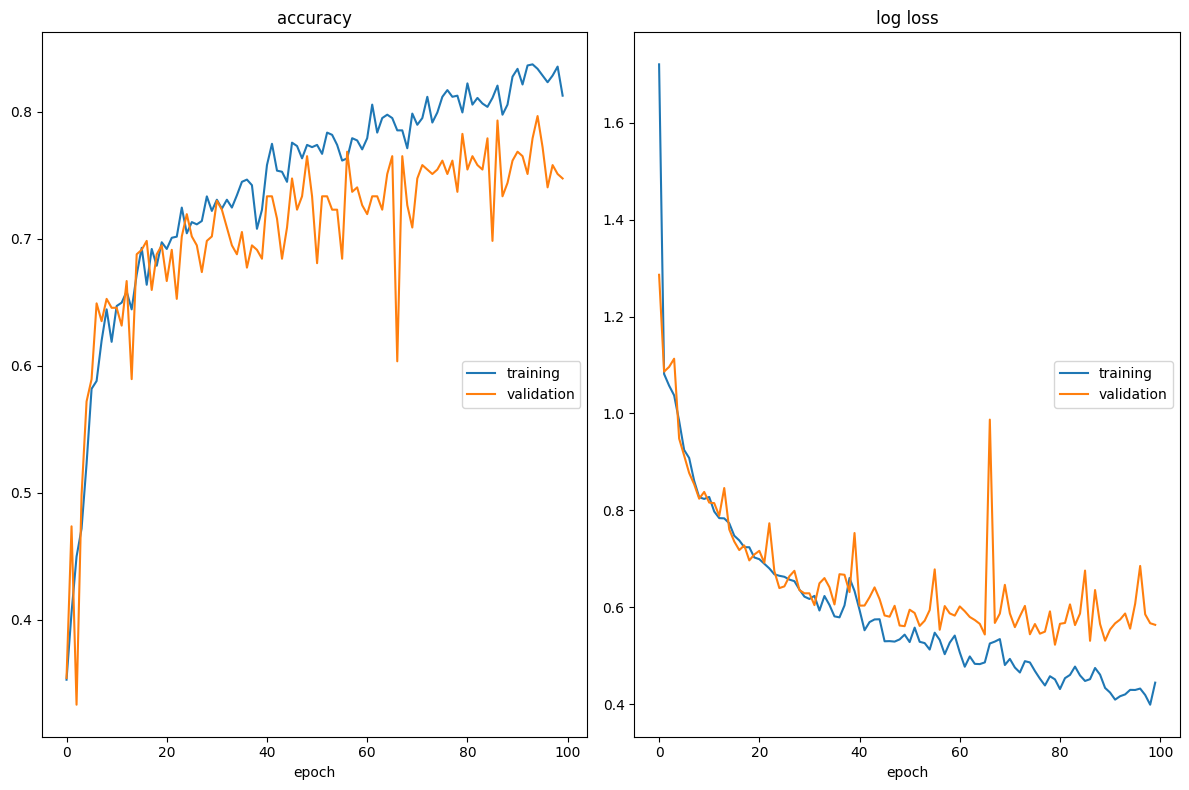

accuracy
	training         	 (min:    0.353, max:    0.837, cur:    0.812)
	validation       	 (min:    0.333, max:    0.796, cur:    0.747)
log loss
	training         	 (min:    0.399, max:    1.720, cur:    0.445)
	validation       	 (min:    0.523, max:    1.286, cur:    0.564)


In [60]:
model = train_model_drbn()

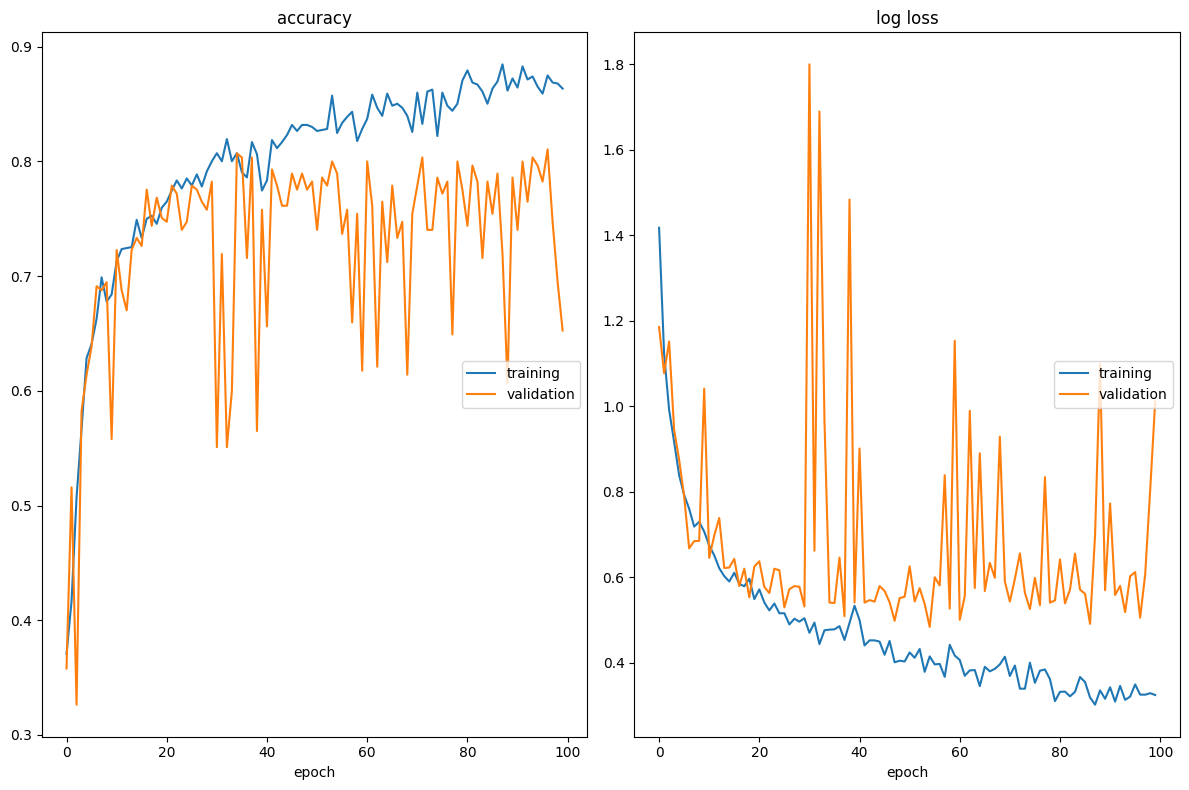

accuracy
	training         	 (min:    0.371, max:    0.885, cur:    0.864)
	validation       	 (min:    0.326, max:    0.811, cur:    0.653)
log loss
	training         	 (min:    0.301, max:    1.417, cur:    0.324)
	validation       	 (min:    0.483, max:    1.800, cur:    1.011)


In [61]:
model = train_model_drbn(lr=5e-3)

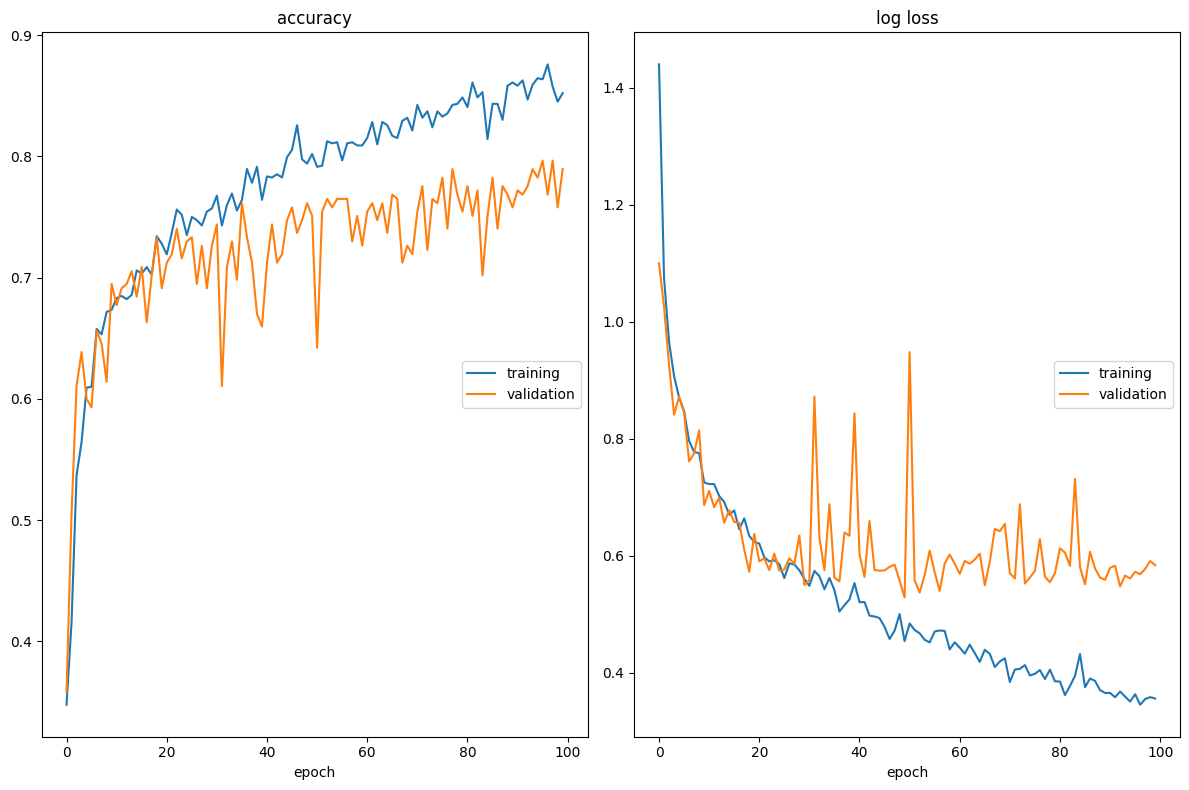

accuracy
	training         	 (min:    0.348, max:    0.876, cur:    0.852)
	validation       	 (min:    0.358, max:    0.796, cur:    0.789)
log loss
	training         	 (min:    0.346, max:    1.440, cur:    0.356)
	validation       	 (min:    0.529, max:    1.100, cur:    0.584)


In [62]:
model = train_model_drbn(batch_size=64)

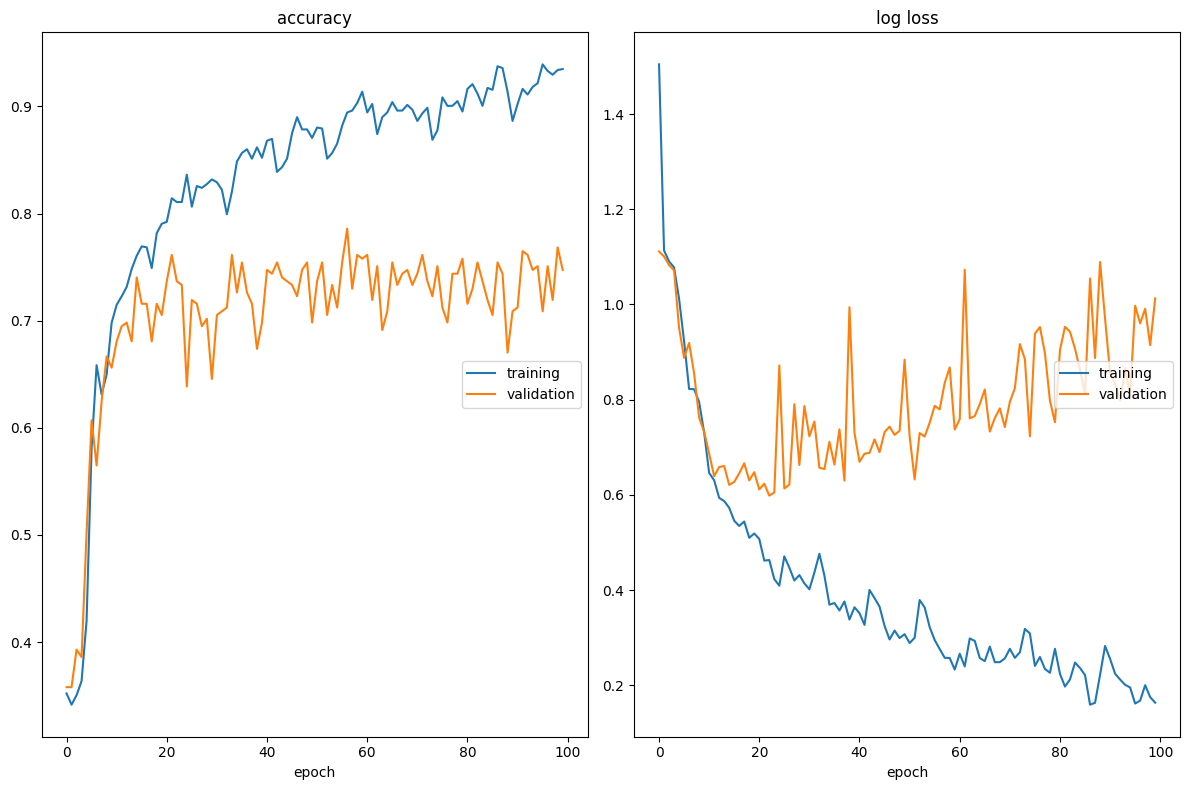

accuracy
	training         	 (min:    0.342, max:    0.939, cur:    0.935)
	validation       	 (min:    0.358, max:    0.786, cur:    0.747)
log loss
	training         	 (min:    0.159, max:    1.504, cur:    0.163)
	validation       	 (min:    0.598, max:    1.111, cur:    1.013)


In [69]:
model = train_adam_model()

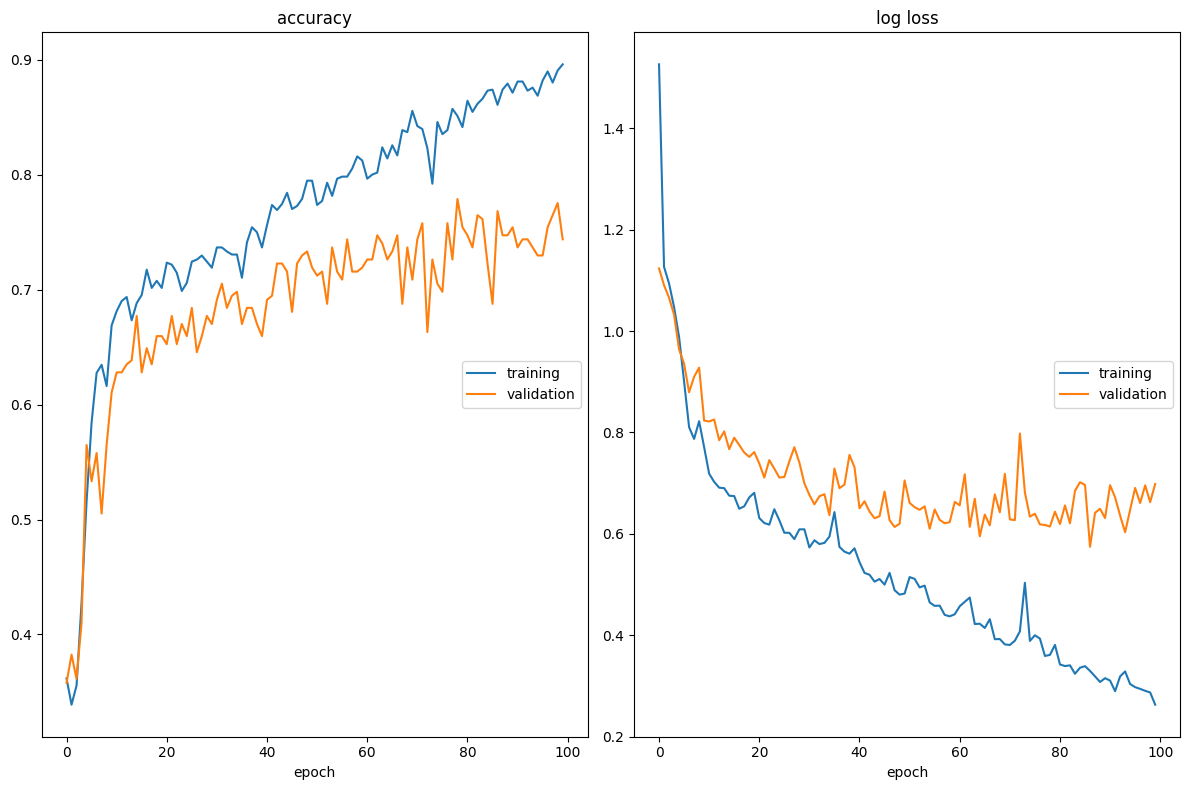

accuracy
	training         	 (min:    0.339, max:    0.896, cur:    0.896)
	validation       	 (min:    0.358, max:    0.779, cur:    0.744)
log loss
	training         	 (min:    0.263, max:    1.526, cur:    0.263)
	validation       	 (min:    0.574, max:    1.123, cur:    0.698)


In [77]:
model = train_adam_model(lr=1e-3)

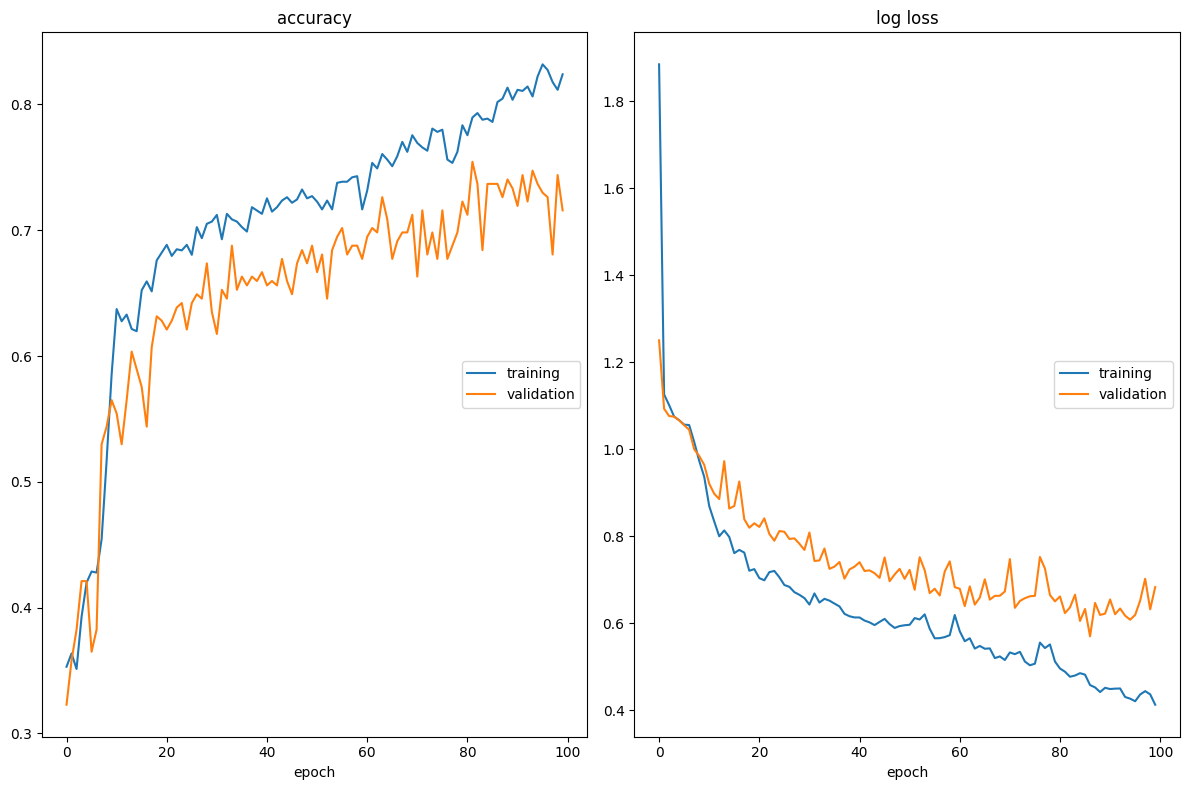

accuracy
	training         	 (min:    0.351, max:    0.832, cur:    0.824)
	validation       	 (min:    0.323, max:    0.754, cur:    0.716)
log loss
	training         	 (min:    0.413, max:    1.885, cur:    0.413)
	validation       	 (min:    0.570, max:    1.250, cur:    0.683)


In [78]:
model = train_adam_model(lr=1e-3, batch_size=128)

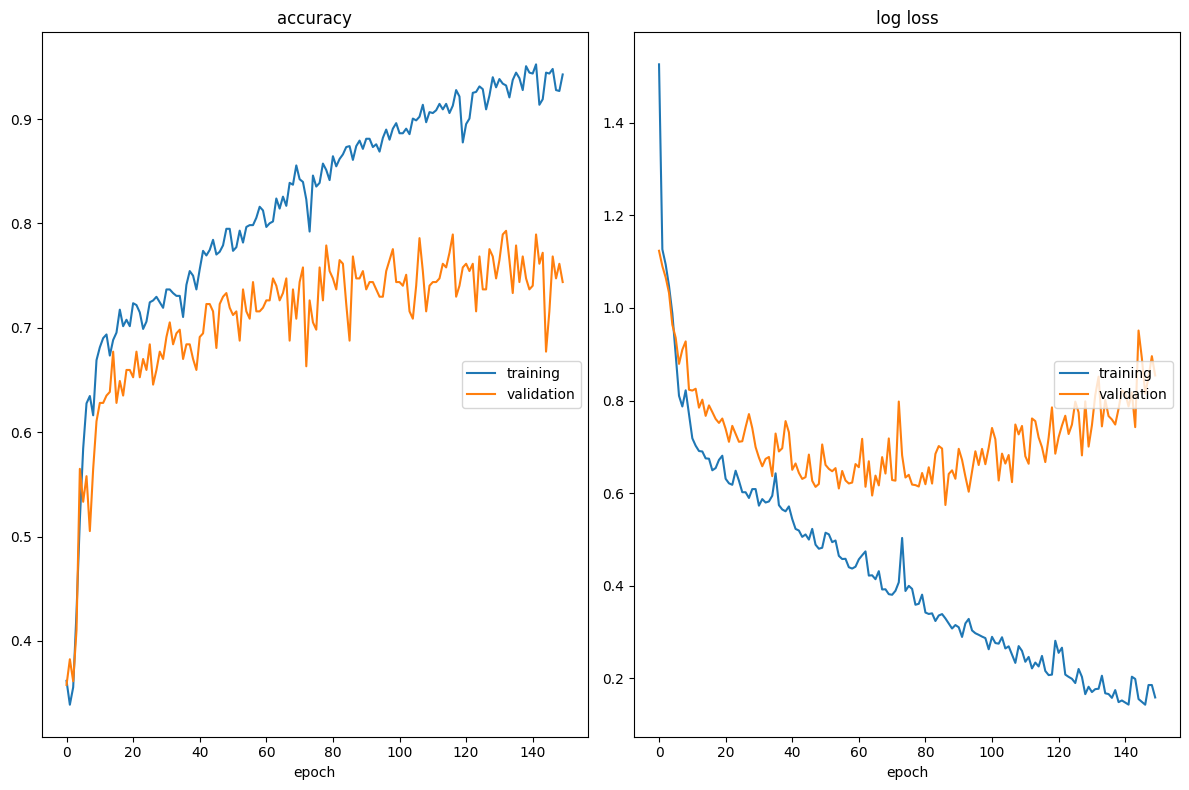

accuracy
	training         	 (min:    0.339, max:    0.952, cur:    0.943)
	validation       	 (min:    0.358, max:    0.793, cur:    0.744)
log loss
	training         	 (min:    0.143, max:    1.526, cur:    0.159)
	validation       	 (min:    0.574, max:    1.123, cur:    0.854)


In [80]:
model = train_adam_model(lr=1e-3, n_epochs=150)

### Observation
- In my implementation, data augmentation didn't really improve the performance